# Detection and Classification Fake newscon social media in the context of covid-19.

## Dataset: CoAid Dataset(Limen C. and Lee D.,2020)

In [2]:

import pandas as pd
#Reading the data from csv file.
df_0=pd.read_csv('real1.csv')

df_1=pd.read_csv('fake1.csv')

df_2=pd.read_csv('real2.csv')

df_3=pd.read_csv('fake2.csv')

df_4=pd.read_csv('real3.csv')

df_5=pd.read_csv('fake3.csv')

df_6=pd.read_csv('real4.csv')

df_7=pd.read_csv('fake4.csv')

#Adding all the data together.

result_fake = pd.concat([df_1,df_3,df_5,df_7], axis=0)
result_real = pd.concat([df_0,df_2,df_4,df_6], axis=0)


result_fake['Label'] = '0' #For fake news Label is 0
print(result_fake.shape)
final_fake_data = result_fake[['title', 'Label']]

result_real['Label'] = '1' #For true news Label is 1
print(result_real.shape)
final_real_data = result_real[['title', 'Label']]

out = final_fake_data.append(final_real_data)

out=out.dropna()#To drop blank entries

out_copy = out.copy() #copying of data


out_new_copy = out_copy.sample(frac=1)
out_new_copy = out_new_copy.reset_index(inplace = False,drop = True) #For shuffling the data
print(out_new_copy)


(925, 16)
(4532, 11)
                                                  title Label
0     Remdesivir & COVID Studies Find Different Results     1
1     As Many as 50 Percent of People with COVID-19 ...     1
2     Obesity May Alter Immune System Response to CO...     1
3     People with Developmental and Behavioral Disor...     1
4     Three Countries Have Kept Coronavirus in Check...     1
...                                                 ...   ...
5452  ÒMass vaccination for COVID-19 in Senegal was ...     0
5453  COVID Worsens Mental Health In The LGBTQ Commu...     1
5454  A large, country-randomized controlled trial w...     0
5455                 Changing Paths During the Pandemic     1
5456  Biden claims that Trump eliminated the White H...     0

[5457 rows x 2 columns]


/var/folders/8w/2387h3ts2635p63jx_mp_1d40000gn/T/ipykernel_65627/2573407772.py:33: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  out = final_fake_data.append(final_real_data)


## Data pre-processing

In [3]:
import re
import nltk #library for data processing
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
corpus = []
for i in range(0, len(out_new_copy)):
    re_view = re.sub(r'[^a-zA-Z0-9]', ' ',out_new_copy['title'][i])
    re_view = re_view.lower()
    re_view = re_view.split()
    
    #re_view = [ps.stem(word) for word in re_view if not word in stopwords.words('english')] #comment this line if you want to run Word2Vec.
    re_view = ' '.join(re_view)
    corpus.append(re_view)

[nltk_data] Downloading package stopwords to /Users/mac/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mac/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:

import gensim
import numpy as np



y = np.asarray(out_new_copy['Label'].astype(str).astype(int))


X = [d.split() for d in corpus]
#Word2Vec model
word2vec_model = gensim.models.Word2Vec(sentences=X, window=10, min_count=1)


word2vec_model.wv.vectors.shape[0]



6742

In [5]:
print(y)

[1 1 1 ... 0 1 0]


In [ ]:
print(X)

In [7]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
# For Tokeniztion
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

2024-07-16 17:04:32.931137: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
X = tokenizer.texts_to_sequences(X)
#tokenizer.word_index

In [ ]:
print(X)

In [10]:
import numpy as np

nos = np.array([len(x) for x in X])
len(nos[nos>30])


87

In [11]:
import keras
from keras.preprocessing.sequence import pad_sequences
maxlen = 100
X = pad_sequences(X,maxlen = maxlen)# for padding
#len(X[0])

In [12]:
print(X)

[[   0    0    0 ...  578  622  261]
 [   0    0    0 ...   31    3   62]
 [   0    0    0 ...    4    1    2]
 ...
 [   0    0    0 ...  600  115  182]
 [   0    0    0 ...   23    3   16]
 [   0    0    0 ...  219   16 1898]]


In [13]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [14]:
def weight_matrix(model): #Generation of matrix
  weight_matrix = np.zeros((vocab_size,100))

  for word ,i in vocab.items():
    weight_matrix[i] = model.wv[word]

  return weight_matrix


In [15]:
#Embedding of matrix.
embedding_vec = weight_matrix(word2vec_model)
embedding_vec.shape

(6743, 100)

In [16]:
import tensorflow 
import tensorflow.keras
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense
from tensorflow.keras.optimizers import Adam

model = keras.Sequential()
model.add(Embedding(vocab_size,output_dim = 100,weights = [embedding_vec],input_length = maxlen,trainable = False))
model.add(LSTM(units = 128))
model.add(Dense(1,activation = 'sigmoid'))
opt = tensorflow.keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt,
              loss=tensorflow.keras.losses.BinaryCrossentropy(),metrics = ['acc'])

/Users/mac/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [17]:
#splitting of data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)


In [18]:
model.fit(X_train,y_train,validation_split=0.3,epochs=10)

Epoch 1/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - acc: 0.7930 - loss: 0.5076 - val_acc: 0.8282 - val_loss: 0.4601
Epoch 2/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 19s 141ms/step - acc: 0.8317 - loss: 0.4633 - val_acc: 0.8282 - val_loss: 0.4587
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 149ms/step - acc: 0.8441 - loss: 0.4339 - val_acc: 0.8282 - val_loss: 0.4647
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 137ms/step - acc: 0.8386 - loss: 0.4413 - val_acc: 0.8282 - val_loss: 0.4584
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 13s 147ms/step - acc: 0.8373 - loss: 0.4502 - val_acc: 0.8282 - val_loss: 0.4645
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 16s 176ms/step - acc: 0.8299 - loss: 0.4606 - val_acc: 0.8282 - val_loss: 0.4649
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 155ms/step - acc: 0.8401 - loss: 0.4224 - val_acc: 0.8282 - val_loss: 0.4028
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 12s 135ms/step - acc: 0.8363 - loss: 0.4001 - val_acc: 0.8534 - val_loss: 0.3627
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 164ms/

In [19]:
y_pred = (model.predict(X_test) >=0.5).astype(int) 
#print(y_pred)

43/43 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step


In [20]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy = accuracy_score(y_test,y_pred)
precision= precision_score(y_test,y_pred,average='weighted')
recall = recall_score(y_test,y_pred,average='weighted')
f1 = f1_score(y_test,y_pred,average='weighted')

In [21]:
#print("Loss",loss)
print("accuracy",accuracy)
print("f1_score",f1)
print("precision",precision)
print("recall",recall)

accuracy 0.852014652014652
f1_score 0.811802830913942
precision 0.8531002877695297
recall 0.852014652014652


In [22]:
#cheecking of model.
x = ["The COVID-19 virus cannot spread in areas sprayed with eucalyptus oil vapor."]
#x = ["A test on video with a gas detector shows that face masks result in dangerous oxygen levels for the wearer."]
x = tokenizer.texts_to_sequences(x)
x = pad_sequences(x,maxlen=maxlen)
#print(x)

In [23]:
#prediction of model
#0 for fake and 1 for true
#model.predict(x)
(model.predict(x) >=0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


array([[1]])

In [32]:
#uncomment the section which one need to use.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
#by using CountVectorizer
#from sklearn.feature_extraction.text import CountVectorizer
#cv = CountVectorizer(max_features=5000,ngram_range=(1,3))
#X = cv.fit_transform(corpus).toarray()

#by using TfidfVectorizer(for multinomial naive bayes alpha=0.2 works best)
#from sklearn.feature_extraction.text import TfidfVectorizer
#cv = TfidfVectorizer()
#X = cv.fit_transform(corpus).toarray()

#by using HashingVectorizer(no features names in hashingvectorizer)
from sklearn.feature_extraction.text import HashingVectorizer
cv = HashingVectorizer(n_features=5000,alternate_sign=False)
X = cv.fit_transform(corpus).toarray()

#print(X)
#X.shape

In [33]:
y = out_new_copy['Label']
#y.shape
#print(y)


In [34]:
#Splitting of data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)

pd.set_option("display.max_rows", 500)
#count_df = pd.DataFrame(X, columns=cv.get_feature_names())

#print(count_df)

In [35]:
#For plotting the confussion matrix.
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [36]:
from sklearn import metrics
import numpy as np
import itertools

models = {}

#Support Vector Machine
from sklearn import svm
models['SVM'] = svm.SVC()


# Support Vector Machines (Linear)
from sklearn.svm import LinearSVC
models['SVM-Linear'] = LinearSVC()

# Naive Bayes Multinomial
from sklearn.naive_bayes import MultinomialNB
models['NB-Multinomial'] = MultinomialNB()

# Naive Bayes Gaussian
from sklearn.naive_bayes import GaussianNB
models['NB-Gaussian'] = GaussianNB()

# Passive Aggressive

from sklearn.linear_model import PassiveAggressiveClassifier
models['Passive Aggressive'] = PassiveAggressiveClassifier()

# Logistic Regression
from sklearn.linear_model import LogisticRegression
models['Logistic Regression'] = LogisticRegression()

# Decision Trees
from sklearn.tree import DecisionTreeClassifier
models['Decision Trees'] = DecisionTreeClassifier()

# Random Forest
from sklearn.ensemble import RandomForestClassifier
models['Random Forest'] = RandomForestClassifier()


# K-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
models['K-Nearest Neighbor'] = KNeighborsClassifier()



In [37]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

accuracy, precision, recall, f1 = {}, {}, {}, {}

for key in models.keys():
    
    # Fit all the classifier models
    models[key].fit(X_train, y_train)
    
    # For all the Prediction 
    predictions = models[key].predict(X_test)
    
    # Foe calculating Accuracy, Precision, Recall and f1-score Metrics
    accuracy[key] = accuracy_score(y_test,predictions)
    precision[key] = precision_score(y_test,predictions,average='weighted')#average='weighted'
    recall[key] = recall_score(y_test,predictions,average='weighted')
    f1[key] = f1_score(y_test,predictions,average='weighted')
    
#Data in dataframe for visualization
df_model = pd.DataFrame(index=models.keys(), columns=['Accuracy', 'Precision', 'Recall','f1-score'])
df_model['Accuracy'] = accuracy.values()
df_model['Precision'] = precision.values()
df_model['Recall'] = recall.values()
df_model['f1-score'] = f1.values()

df_model

/Users/mac/anaconda3/lib/python3.11/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


,Accuracy,Precision,Recall,f1-score
SVM,0.920044,0.916877,0.920044,0.913796
SVM-Linear,0.929484,0.926751,0.929484,0.927253
NB-Multinomial,0.851749,0.873987,0.851749,0.793709
NB-Gaussian,0.644642,0.800132,0.644642,0.691200
Passive Aggressive,0.921710,0.921386,0.921710,0.921544
Logistic Regression,0.911160,0.907087,0.911160,0.902849
Decision Trees,0.894503,0.888837,0.894503,0.890715
Random Forest,0.911716,0.914023,0.911716,0.899373
K-Nearest Neighbor,0.887840,0.877975,0.887840,0.877853


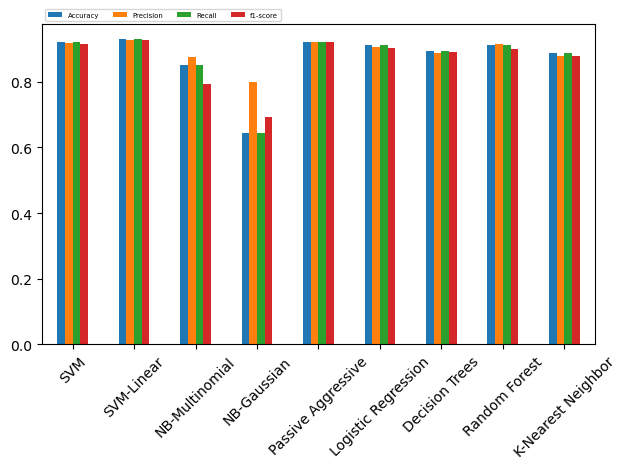

In [38]:
#For graphical representation of performance of classifiers.
import matplotlib.pyplot as plt
ax  = df_model.plot.bar(rot=45)
ax.legend(ncol= len(models.keys()), bbox_to_anchor=(0, 1), loc='lower left', prop={'size': 5})
plt.tight_layout()